In [21]:
import pandas as pd
import nltk
import re
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from collections import Counter, defaultdict
from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from torch.utils.data import DataLoader, TensorDataset
from datasets import load_dataset

In [23]:

data = pd.read_csv("combined_articles_final.csv")
data

,id,title,link,content,gold_label
0,0,ہم لکھنے والے ایک بے ایمان معاشرہ میں سانس لے ...,https://urdu.arynews.tv/intezar-hussain-urdu-w...,سوچتا ہوں غالب س کتن مختلف زمان جی رہ ہیں شخص ...,entertainment
1,1,’’کیا اُدھر باغ بھی ہے؟‘‘,https://urdu.arynews.tv/lakhnau-nawab-mahalsara/,محمد حسین آزاد ن میر ک بار واقعہ لکھا ہ انھوں...,entertainment
2,2,کچھ زخمی کہہ رہے تھے کہ وہ زندہ ہیں…,https://urdu.arynews.tv/politics-and-politicia...,وطنِ عزیز سیاست دار و مدار رہ ہ جماعت ن کتنا ب...,entertainment
3,3,آگرے والا عبدالکریم اور ملکہ وکٹوریہ,https://urdu.arynews.tv/munshi-abdul-karim-and...,پیار شوہر البرٹ ب حد عزیز ملازم جان بران ک مرن...,entertainment
4,4,"""چچی سیدانی تھیں….”",https://urdu.arynews.tv/aslam-parvez-khaka/,خاکہ نگاری اردو مقبول صنف رہی ہ زیادہ تر اہلِ ...,entertainment
...,...,...,...,...,...
1482,1482,حماس کی جانب سے رہا کی گئی اسرائیلی لڑکی نے من...,https://jang.com.pk/news/1415862,حماس جانب س جان والی اسرایلی نوجوان لڑکی ن منگ...,world
1483,1483,روسی صدر پیوٹن کی انجیلا مرکل کو کتے سے ڈرانے ...,https://jang.com.pk/news/1415855,روس ک صدر ولادیمیر پیوٹن ن سابق جرمن چانسلر ان...,world
1484,1484,چین میں دنیا کا سب سے بڑا سونے کا ذخیرہ دریافت,https://jang.com.pk/news/1415840,دنیا س بڑا سون ذخیرہ چین دریافت ہ غیر ملکی میڈ...,world
1485,1485,یوکرین کو جوہری ہتھیار ملے تو تمام فوجی وسائل ...,https://jang.com.pk/news/1415837,روس ک صدر ولادیمیر پیوٹن ن ہ یوکرین جوہری ہتھی...,world


In [5]:
stopwords = {
    'اور', 'ایک', 'کو', 'ہے', 'میں', 'کی', 'سے', 'پر', 'ہو', 'یہ', 'کا', 'اس', 'کہ', 'کر', 'تھا', 'تھی', 'تھے', 
    'لیے', 'بھی', 'نے', 'جو', 'ہوا', 'وہ', 'کیا', 'جا', 'نہ', 'تو', 'یا', 'کرنے', 'گیا', 'کر', 'دیا', 
    'لیکن', 'بہت', 'آپ', 'ہم', 'سب', 'کچھ', 'اپنے', 'ان', 'کردی', 'اگر', 'ہوتی', 'اب', 'مجھے', 'اسی', 'جس', 'اسے', 
    'اپنی', 'کسی', 'ہوتا', 'انہوں', 'تھیں', 'کہا', 'جب', 'اُس', 'کل', 'کوئی', 'ہوتے', 'تم', 'کس', 'رہا', 'کن', 'ایسے', 
    'جاتا', 'اسی', 'اُن', 'رہے', 'گئے', 'جاتی', 'تھے', 'اُنہوں', 'اُسی', 'بنی', 'بعد', 'چاہیے', 'بین', 'پھر', 'اُنکا', 'ہونے'
}

In [7]:
def preprocess_text(text, stopwords_list):
    tokens = text.lower().split()  # Lowercase and split
    tokens = [token for token in tokens if token.isalnum()]  
    return ' '.join([token for token in tokens if token not in stopwords_list])  # Remove stopwords


# Preprocess the data
data['processed_content'] = data['content'].apply(lambda x: preprocess_text(x, stopwords))
data['processed_content'].head()



0    سوچتا ہوں غالب س کتن مختلف زمان جی رہ ہیں شخص ...
1    محمد حسین ن میر ک بار واقعہ لکھا ہ انھوں ن اپن...
2    عزیز سیاست دار و مدار رہ ہ جماعت ن کتنا بڑا جل...
3    پیار شوہر البرٹ ب حد عزیز ملازم جان بران ک مرن...
4    خاکہ نگاری اردو مقبول صنف رہی ہ زیادہ تر قلم ن...
Name: processed_content, dtype: object

In [9]:
# Split the data into train and test sets (80% train, 20% test)
train_data, test_data, train_labels, test_labels = train_test_split(data['processed_content'], 
    data['gold_label'], test_size=0.2, random_state=42)
print(train_data.shape)
print(test_data.shape)
print(train_labels.shape)
print(test_labels.shape)

(1189,)
(298,)
(1189,)
(298,)


In [11]:
class BagOfWords:
    def __init__(self):
        self.vocabulary_ = {}
        self.vocabulary_size_ = 0
    
    def fit(self, corpus):
        
        word_set = set()
        for sentence in corpus:
            word_set.update(sentence.split())
        
        self.vocabulary_ = {word: idx for idx, word in enumerate(sorted(word_set))}
        self.vocabulary_size_ = len(self.vocabulary_)
    
    def vectorize(self, sentence):
        """Convert a sentence into a bag-of-words vector."""
        words = sentence.split()
        vector = np.zeros(self.vocabulary_size_, dtype=int)
        for word in words:
            if word in self.vocabulary_:
                vector[self.vocabulary_[word]] += 1
        return vector



bow = BagOfWords()
bow.fit(train_data)

X_train_vectors = np.array([bow.vectorize(text) for text in train_data])
X_test_vectors = np.array([bow.vectorize(text) for text in test_data])
print(X_train_vectors.shape)
print(X_test_vectors.shape)

(1189, 16470)
(298, 16470)


Model 1 Multinomial Naive Bayes

In [13]:
class MultinomialNaiveBayes:
    def __init__(self, alpha=1.0): 
        self.alpha = alpha
        self.class_priors = {}
        self.cond_probs = {}
        self.classes = []
        self.vocab_size = 0

    def fit(self, X, y):
        if not isinstance(X, np.ndarray):
            X = X.toarray()  
        
        self.classes, class_counts = np.unique(y, return_counts=True)
        self.vocab_size = X.shape[1]
        total_count = len(y)
        self.class_priors = {cls: count / total_count for cls, count in zip(self.classes, class_counts)}

        for cls in self.classes:
            class_indices = np.where(y == cls)[0]
            class_word_counts = X[class_indices].sum(axis=0)
            total_words = class_word_counts.sum()
            self.cond_probs[cls] = (class_word_counts + self.alpha) / (total_words + self.alpha * self.vocab_size)

    def predict(self, X):
        if not isinstance(X, np.ndarray):
            X = X.toarray()  
        
        predictions = []
        for x in X:
            log_probs = {}
            for cls in self.classes:
                log_prob = np.log(self.class_priors[cls]) + np.sum(np.log(self.cond_probs[cls]) * x)
                log_probs[cls] = log_prob
            predictions.append(max(log_probs, key=log_probs.get))
        return np.array(predictions)



Accuracy: 0.9631
Precision: 0.9625
Recall: 0.9644
F1 Score: 0.9626


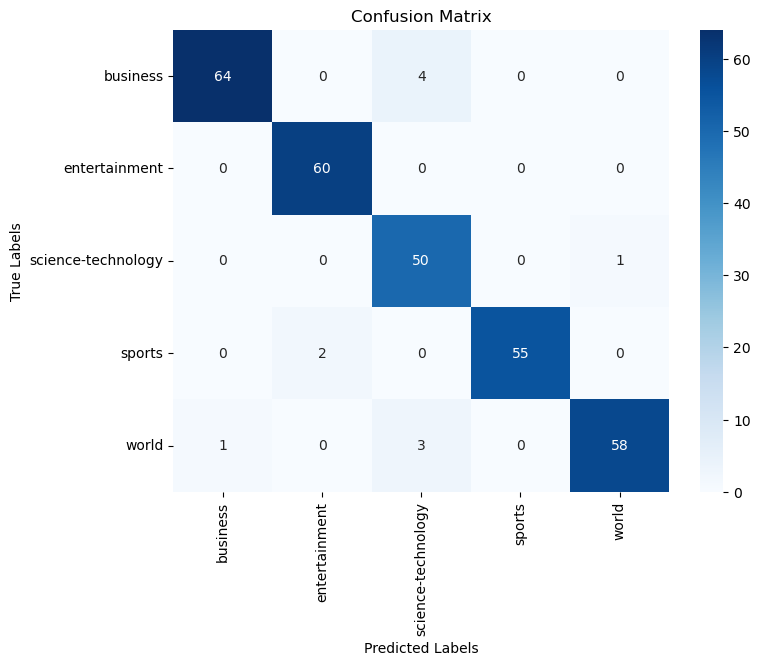

In [19]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


nb = MultinomialNaiveBayes()
nb.fit(X_train_vectors, train_labels)

y_pred = nb.predict(X_test_vectors)


accuracy = accuracy_score(test_labels, y_pred)
precision = precision_score(test_labels, y_pred, average='macro', zero_division=0)
recall = recall_score(test_labels, y_pred, average='macro', zero_division=0)
f1 = f1_score(test_labels, y_pred, average='macro', zero_division=0)

# Print metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

cm = confusion_matrix(test_labels, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues',
            xticklabels=np.unique(test_labels),
            yticklabels=np.unique(test_labels))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()